<p>
  <b>AI Lab: Deep Learning for Computer Vision</b><br>
  <b><a href="https://www.wqu.edu/">WorldQuant University</a></b>
</p>

<div class="alert alert-success" role="alert">
  <p>
    <center><b>Usage Guidelines</b></center>
  </p>
  <p>
    This file is licensed under <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International</a>.
  </p>
  <p>
    You <b>can</b>:
    <ul>
      <li><span style="color: green">✓</span> Download this file</li>
      <li><span style="color: green">✓</span> Post this file in public repositories</li>
    </ul>
    You <b>must always</b>:
    <ul>
      <li><span style="color: green">✓</span> Give credit to <a href="https://www.wqu.edu/">WorldQuant University</a> for the creation of this file</li>
      <li><span style="color: green">✓</span> Provide a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">link to the license</a></li>
    </ul>
    You <b>cannot</b>:
    <ul>
      <li><span style="color: red">✗</span> Create derivatives or adaptations of this file</li>
      <li><span style="color: red">✗</span> Use this file for commercial purposes</li>
    </ul>
  </p>
  <p>
    Failure to follow these guidelines is a violation of your terms of service and could lead to your expulsion from WorldQuant University and the revocation your certificate.
  </p>
</div>

### Getting Ready

Before we start this lesson, we need to load the libraries we'll be using. These are the same ones we used in the last project.

In [1]:
import os
import random
from shutil import copy2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

And we should check what versions we are using. This way we know what versions worked, in case something changes in an update.

In [2]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

!python --version

torch version :  2.2.2+cu121
torchvision version :  0.17.2+cu121
numpy version :  1.26.3
matplotlib version :  3.9.2
Python 3.11.0


### Exploring Our Dataset

<div class="alert alert-danger" role="alert">
  <p>
    <center><b>Warning! Content Updated!</b></center>
  </p>
  <p>
    This notebook has been update since the original creation and recording of the video. Originally, this notebook pulled data from GCP, but we've made a change so it's always available without the need of pulling it.
  </p>
</div>

Our data for this project is related to a [Kaggle competition](https://www.kaggle.com/competitions/cassava-leaf-disease-classification) about crops in Uganda. Here, we'll work with images of cassava plants, an extremely important staple crop. We have images of both healthy plants, and plants with one of four diseases. The goal of the competition is to create a model to diagnose what disease a plant has, or if it's healthy. This would be the first step toward speeding up this diagnosis to help farmers maintain their crops.

We'll specifically be looking at images from this [Kaggle Dataset](https://www.kaggle.com/datasets/srg9000/cassava-plant-disease-merged-20192020), which has data from the 2019 and 2020 versions of this competition.

**Content Update Warning**

The data is available at the location `data_p2/train`. You can explore the dataset freely and then move to the next section.

In [3]:
!ls -l data_p2

total 8
drwxrwxr-x 2 nobody nogroup 4096 Oct 21  2024 test
drwxrwxr-x 7 nobody nogroup 4096 Oct 21  2024 train


**Task 2.2.1:** Create a variable for the `train` directory.

In [4]:
data_dir = "data_p2"
train_dir = os.path.join(data_dir, "train")

print("Data directory:", train_dir)

Data directory: data_p2/train


In the training directory, each class gets its own directory. There are five categories:

- healthy
- green mottle virus (CGM)
- bacterial blight (CBB)
- brown streak disease (CBSD)
- mosaic disease (CMD)

We'll use the directory names as our classes.

In [5]:
classes = os.listdir(train_dir)
classes

['cassava-healthy',
 'cassava-mosaic-disease-cmd',
 'cassava-brown-streak-disease-cbsd',
 'cassava-green-mottle-cgm',
 'cassava-bacterial-blight-cbb']

Let's look at a few examples of each. The function below opens four randomly selected images with the `PIL` library we used in the previous project, and displays them in a line.

In [6]:
def sample_images(data_path, classname):
    # Gets the files in the directory
    class_dir = os.path.join(data_path, classname)
    if not os.path.exists(class_dir):
        return "Invalid directory"
    image_list = os.listdir(class_dir)
    if len(image_list) < 4:
        return "Not enough images in folder"

    # Pick four random images
    images_sample = random.sample(image_list, 4)

    # Plot them
    plt.figure(figsize=(20, 20))
    for i in range(4):
        img_loc = os.path.join(class_dir, images_sample[i])
        img = PIL.Image.open(img_loc)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

It takes two arguments:
- The directory containing the classes
- Which class we want

First, let's look at some healthy plants.

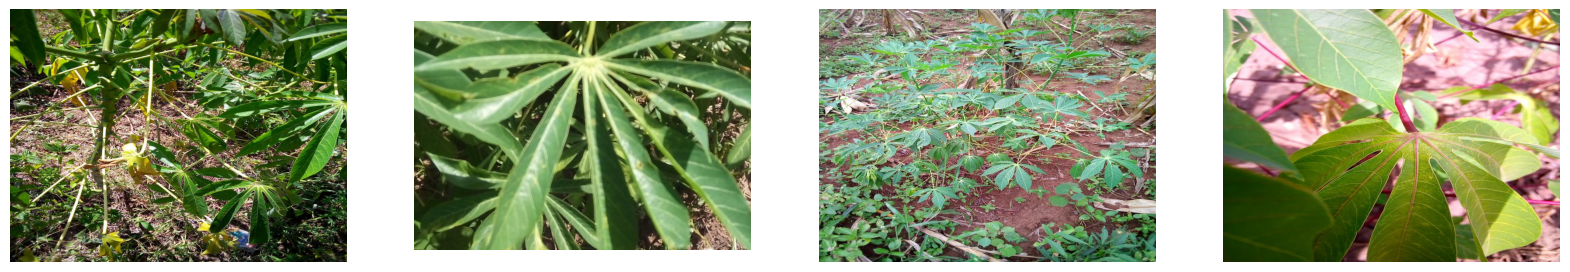

In [7]:
sample_images(train_dir, "cassava-healthy")

Now we can look at the four disease classes. Instead of writing out the class name by hand, you can use the `classes` variable that has all of them in it.

**Task 2.2.2:** Use the `sample_images` function to look at examples of the first disease class (green mottle virus).

In [ ]:
class_name = ...
print(class_name)

sample_images(..., class_name)

**Task 2.2.3:** Use the `sample_images` function to look at examples of the second disease class (bacterial blight).

In [ ]:
class_name = 
print(class_name)

sample_images(..., class_name)

If you're using the `classes` variable, be careful about order. We want to skip over the healthy plants, since we've already seen them.

**Task 2.2.4:** Use the `sample_images` function to look at examples of the third disease class (brown streak disease).

In [ ]:
class_name = ...
print(class_name)

sample_images(..., class_name)

**Task 2.2.5:** Use the `sample_images` function to look at examples of the fourth disease class (mosaic disease).

In [ ]:
class_name = ...
print(class_name)

sample_images(..., class_name)

### Preparing Our Data

Now that we've seen the images we're working with, we need to get them ready for PyTorch. We'll use the same tools as the last project to load in the data.

We'll create transformations that:

- Convert any grayscale images to RGB format with a custom class
- Resize the image, so that they're all the same size (we chose $224$ x $224$, but other sizes would work as well)
- Convert the image to a Tensor of pixel values

In [ ]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [ ]:
transform_basic = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

We'll want to apply these transformations as we load in the data. We'll also want to break our dataset into batches. We can use `ImageFolder` and `DataLoader` in the same way we did in the last project.

**Task 2.2.6:** Use `ImageFolder` to create a dataset applying the `transform_basic`, and `DataLoader` to create a data loader. Use a batch size of $32$.

In [ ]:
batch_size = ...
dataset = ...
dataset_loader = ...

batch_shape = next(iter(dataset_loader))[0].shape
print("Getting batches of shape:", batch_shape)

### Normalized Data

In the last project, we saw that normalized data made our network perform better. That is data with a mean of $0$ and a standard deviation of $1$. We'll want to normalize this data as well.

This is the function we used in the last project to compute the mean and standard deviation of our images.

In [ ]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

**Task 2.2.7:** Run the `get_mean_std` function on the `dataset_loader`, and save the means and standard deviations to variables `mean` and `std`. There should be a value for each color channel, giving us vectors of length $3$.

In [ ]:
mean, std = ...

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

As expected, the means aren't $0$ and the standard deviations aren't $1$. We'll again change our transformations to include a `Normalize`. As in the last project, we need to give it a mean and standard deviation for each color channel. This is what we computed with our function.

In [ ]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

We'll need to recreate this dataset using the new transformations.

**Task 2.2.8:** Make a new normalized dataset using `ImageFolder` and a new `DataLoader`. Be sure to use a the same batch size of $32$.

In [ ]:
norm_dataset = ...
norm_loader = ...

batch_shape = next(iter(norm_loader))[0].shape
print("Getting batches of shape:", batch_shape)

After the new normalize transformation, the data should have mean $0$ and standard deviation $1$ in each color channel. Let's check that.

**Task 2.2.9:** Use the `get_mean_std` function to verify the mean and standard deviation are correct in the `norm_loader` data.

In [ ]:
norm_mean, norm_std = ...

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

That has mean zero, to within rounding error, and standard deviation $1$. We're ready to move on.

<div class="alert alert-info" role="alert">
As mentioned in the previous project, this isn't the right way to do this. We should separate out the training set <i>first</i>, and use its mean and standard deviation. That avoids the possibility of information about the validation set "leaking" into the training set. For just the mean and standard deviation, this isn't really a problem. But for almost anything more complicated it is. <br><br>

The reason we haven't done this properly is PyTorch. The way we're doing it is vastly simpler to implement.
</div>

### Train-Validation Split

The next thing we'll need to do is create a training dataset and a validation dataset. We can use the `random_split` tool as we did in the last project.

**Task 2.2.10:** Use `random_split` to create a training dataset with 80% of the data, and a validation dataset with 20% of the data. Be sure to use `norm_dataset`.

In [ ]:
train_dataset, val_dataset = ...

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

As in the previous project, we want to make sure the training data and validation data are similar. We'll want to double check that the two sets have similar proportions of each class.

In the previous project, we used a `class_counts` function to count how many observations were in each class. This function is now in the `training.py` file, so we can import it from there. The function takes a dataset (not a data loader) and returns a `pandas` Series of the counts of each class.

In [ ]:
from training import class_counts

And we can run it to get the number of images in each class in the training set.

In [ ]:
train_counts = class_counts(train_dataset)
train_counts

And we can use `pandas` to make a bar chart.

In [ ]:
train_counts.plot(kind="bar");

To be able to compare, we'll need to make the same plot for the validation data.

**Task 2.2.11:** Use `class_counts` to make a `pandas` Series from the validation data, and create the bar chart from it.

In [ ]:
val_counts = ...

# Create a bar chart from val_counts


<div class="alert alert-info" role="alert">
The random split tool does exactly what it says. It takes the data points and randomly puts 80% in one group and 20% in the other. Of course, we chose 80% and 20%, and could have made a different choice. But it isn't looking at which class a point is in. We're counting on the fact that the random sampling should roughly evenly split each class by chance. This might not happen if we have a small data set. But ours is large enough we shouldn't have to worry.
</div>

### Unbalanced Classes

Unless you got really unlucky, the two graphs should be very similar. 

But the different classes have different numbers of images. There are fewer bacterial blight images, and more brown streak disease and mosaic disease images. This can cause our model to be biased — it will be less likely to call an image bacterial blight. But that doesn't reflect the world, just our training set!

This is an example of _unbalanced classes_. We can correct this by adjusting our dataset. We can either get more images until they're about the same, or remove images from the ones with more.

Since we can't get more images, we'll remove some from the larger classes. This is called _undersampling_. The function below will do this for us.

In [ ]:
def undersample_dataset(dataset_dir, output_dir, target_count=None):
    """
    Undersample the dataset to have a uniform distribution across classes.

    Parameters:
    - dataset_dir: Path to the directory containing the class folders.
    - output_dir: Path to the directory where the undersampled dataset will be stored.
    - target_count: Number of instances to keep in each class. If None, the class with the least instances will set the target.
    """
    # Mapping each class to its files
    classes_files = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            files = os.listdir(class_dir)
            classes_files[class_name] = files

    # Determine the minimum class size if target_count is not set
    if target_count is None:
        target_count = min(len(files) for files in classes_files.values())

    # Creating the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Perform undersampling
    for class_name, files in classes_files.items():
        print("Copying images for class", class_name)
        class_output_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(class_output_dir):
            os.makedirs(class_output_dir)

        # Randomly select target_count images
        selected_files = random.sample(files, min(len(files), target_count))

        # Copy selected files to the output directory
        for file_name in tqdm(selected_files):
            src_path = os.path.join(dataset_dir, class_name, file_name)
            dst_path = os.path.join(class_output_dir, file_name)
            copy2(src_path, dst_path)

    print(f"Undersampling completed. Each class has up to {target_count} instances.")

The function works directly with the image files. We tell it what directory contains our data, and where to put the new dataset. We'll create a new directory `data_p2/data_undersampled/train` and write files there.

**Task 2.2.12:** Create a variable `output_dir` for the new directory `data_p2/data_undersampled/train`.

In [ ]:
output_dir = ...
print("Output directory:", output_dir)

We'll erase that directory if it already exists, and run our function to create a new, balanced dataset.

In [ ]:
! rm -rf {output_dir}

In [ ]:
undersample_dataset(train_dir, output_dir)

The claim is that all classes should have the same number of images now. Let's check that by running our count. We'll need to create a new dataset first, using the new data.

**Task 2.2.13:** Create a dataset with `ImageFolder` using the data in the `output_dir`. Transform the data with the `transform_norm`.

In [ ]:
undersampled_dataset = ...

This data should have the same classes as before.

In [ ]:
undersampled_dataset.classes

And all the classes should now have the same number of counts. If we recreate the bar plot, every bar should be the same height. We'll also print out the counts to make sure they're _exactly_ the same.

**Task 2.2.14:** Use `class_counts` to make a `pandas` Series from the undersampled data, and create the bar chart from it.

In [ ]:
# Important, don't change this
fig, ax = plt.subplots(figsize=(10, 6))

under_counts = ...

# Create a bar chart from under_counts
# important, you must leave `ax=ax`
under_counts.plot(..., ax=ax)

As we hoped, every class has the same number of images. We'll use this data in later lessons to train our models.

### Conclusion

Good work! We now have data that is normalized and has balanced classes. This will help our models perform better, and make them less likely to favor one class over another. Here are the key ideas we encountered:

- Our data needs to be loaded and processed
- We can normalize our data to help our models
- If we have unbalanced classes, our model might favor one class over another
- We can correct this by undersampling, throwing away data in the larger classes

In the following lessons, we'll use this data to train several different models. We'll strive towards getting the best classification we can, to give farmers the right information to treat their crops.

---
This file &#169; 2024 by [WorldQuant University](https://www.wqu.edu/) is licensed under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/).